In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wiggle_bin_simulation import simulate

In [2]:
def add_worm_temperature_zones():
    """Add worm comfort and danger temperature zones as horizontal lines to a plot."""
    plt.axhline(35, linestyle='--', color='red', label='Worm Danger Max (35°C)')
    plt.axhline(30, linestyle='--', color='green', label='Worm Comfort Max (30 °C)')
    plt.axhline(15, linestyle='--', color='green', label='Worm Comfort Min (15 °C)')
    plt.axhline(5, linestyle='--', color='orange', label='Worm Slow Down Min (5 °C)')
    plt.axhline(0, linestyle='--', color='red', label='Worm Danger Min (0 °C)')

# 2019

In [3]:
import xarray as xr

# Load dataset
year_2019_temp = xr.open_dataset("emwcf/2019-2h-interval/instant.nc")  # temperatures
year_2019_rad = xr.open_dataset("emwcf/2019-2h-interval/accum.nc")  # radiation

year_2019_combined = xr.merge([year_2019_temp, year_2019_rad])

# Convert to DataFrame
year_2019 = year_2019_combined.to_dataframe().reset_index()

# Convert Kelvin to Celsius
year_2019['temp'] = year_2019['t2m'] - 273.15
year_2019['soil_0_7'] = year_2019['stl1'] - 273.15

# Convert J/m² to W/m²
year_2019['sun'] = year_2019['ssrd'] / 3600

In [4]:
year_2019 = year_2019.rename(columns={"valid_time": "time"})
year_2019['month'] = pd.to_datetime(year_2019['time']).dt.month
year_2019 = year_2019.set_index('time')

In [ ]:
# Ensure index is datetime
year_2019.index = pd.to_datetime(year_2019.index)

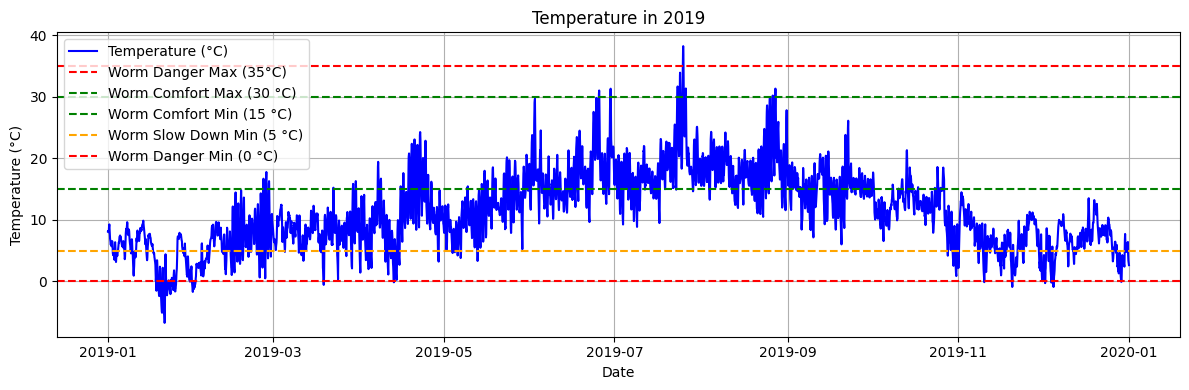

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(year_2019.index, year_2019['temp'], label='Temperature (°C)', color='blue')
add_worm_temperature_zones()
plt.title("Temperature in 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Winter and summer model

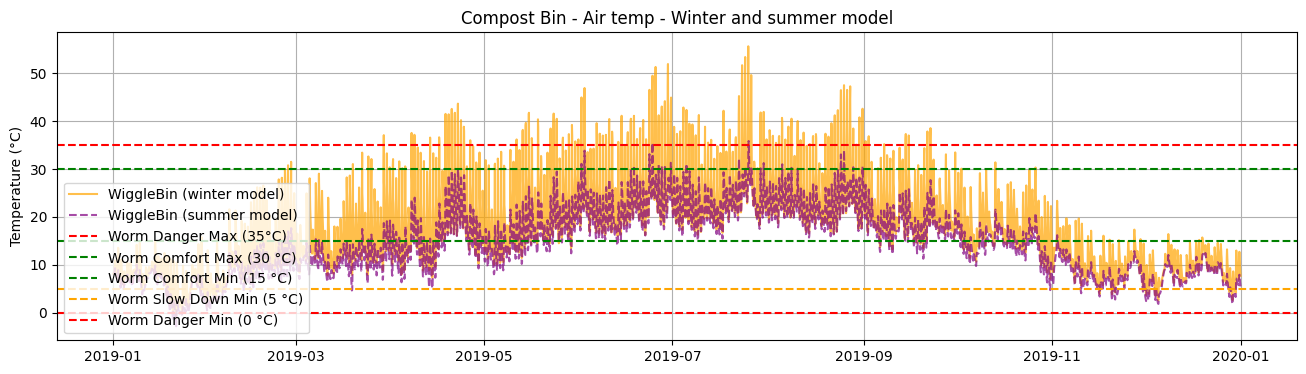

In [24]:
# air ambient
year_2019['bin_winter_model'] = simulate(
    year_2019,
    partial_shade=True,
    color='black',
    insulation=True,
    auto_venting_lid=True
)
year_2019['bin_summer_model'] = simulate(
    year_2019,
    partial_shade=True,
    color='white',
    insulation=True,
    auto_venting_lid=True,
    shade_on_hot_days=True
)

plt.figure(figsize=(16, 4))
# plt.plot(selected_summer.index, selected_summer['temp'], label='Air Temp', color='skyblue')
# plt.plot(selected_summer.index, selected_summer['soil_0_7'], label='Soil Temp', color='brown', linestyle="--", alpha=0.5)
plt.plot(year_2019.index, year_2019['bin_winter_model'], label='WiggleBin (winter model)', color='orange', alpha=0.7)
plt.plot(year_2019.index, year_2019['bin_summer_model'], label='WiggleBin (summer model)', color='purple', alpha=0.7, linestyle="--")
plt.title("Compost Bin - Air temp - Winter and summer model")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower left')
plt.grid()
plt.show()

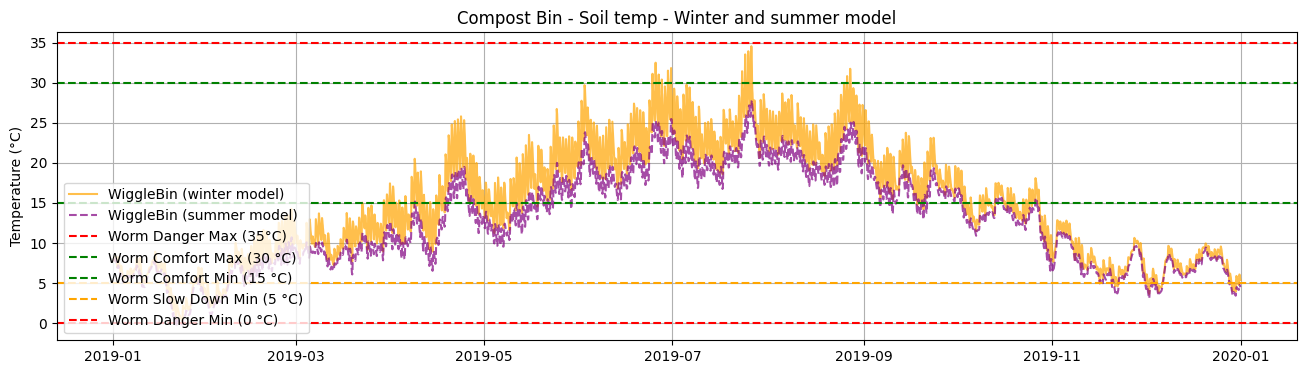

In [11]:
# soil ambient
year_2019['bin_winter_model_soil'] = simulate(
    year_2019,
    partial_shade=True,
    color='black',
    insulation=True,
    auto_venting_lid=True,
    use_soil_as_ambient=True
)
year_2019['bin_summer_model_soil'] = simulate(
    year_2019,
    partial_shade=True,
    color='white',
    insulation=True,
    auto_venting_lid=True,
    shade_on_hot_days=True,
    use_soil_as_ambient=True
)

plt.figure(figsize=(16, 4))
# plt.plot(selected_summer.index, selected_summer['temp'], label='Air Temp', color='skyblue')
# plt.plot(selected_summer.index, selected_summer['soil_0_7'], label='Soil Temp', color='brown', linestyle="--", alpha=0.5)
plt.plot(year_2019.index, year_2019['bin_winter_model_soil'], label='WiggleBin (winter model)', color='orange', alpha=0.7)
plt.plot(year_2019.index, year_2019['bin_summer_model_soil'], label='WiggleBin (summer model)', color='purple', alpha=0.7, linestyle="--")
plt.title("Compost Bin - Soil temp - Winter and summer model")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower left')
plt.grid()
plt.show()

### Winter bin in Winter and Summer bin in Summer

In [51]:
year_2019['bin_mixed_model'] = year_2019.apply(
    lambda row: row['bin_winter_model'] if row.name.month in [1, 2, 3, 10, 11, 12] else row['bin_summer_model'],
    axis=1
)
year_2019['bin_mixed_model_soil'] = year_2019.apply(
    lambda row: row['bin_winter_model_soil'] if row.name.month in [1, 2, 3, 10, 11, 12] else row['bin_summer_model_soil'],
    axis=1
)

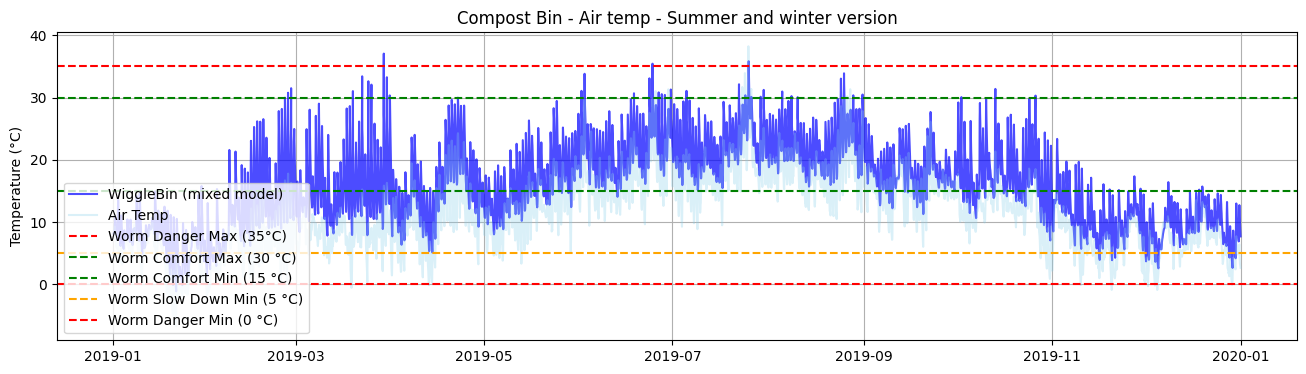

In [52]:
plt.figure(figsize=(16, 4))
plt.plot(year_2019.index, year_2019['bin_mixed_model'], label='WiggleBin (mixed model)', color='blue', alpha=0.7)
plt.plot(year_2019.index, year_2019['temp'], label='Air Temp', color='skyblue', alpha=0.3)
plt.title("Compost Bin - Air temp - Summer and winter version")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [53]:
comparison = year_2019[['temp', 'bin_mixed_model']].describe()
print(comparison)

              temp  bin_mixed_model
count  5840.000000      5840.000000
mean     11.360023        16.045330
std       6.214890         6.486259
min      -6.765961        -1.154046
25%       6.815765        10.862594
50%      10.809113        16.126769
75%      15.811493        20.884111
max      38.244537        37.064667


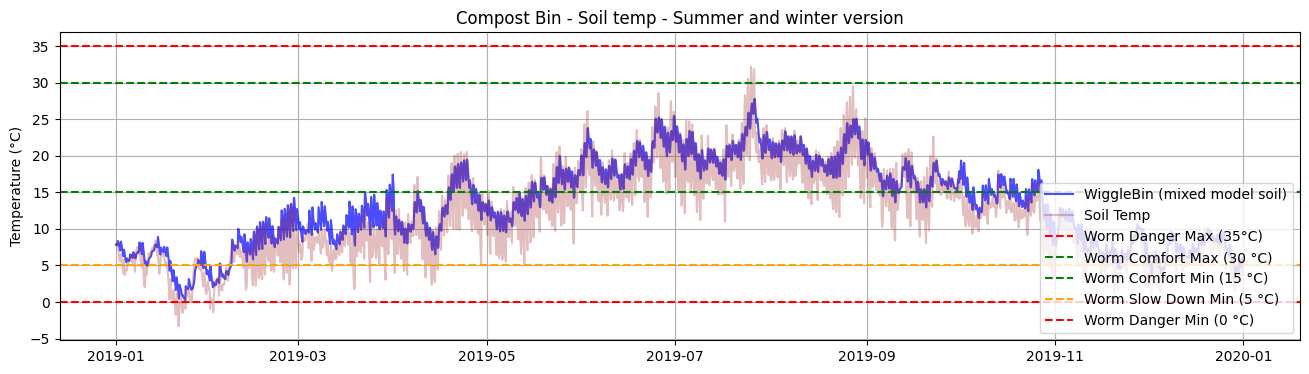

In [54]:
plt.figure(figsize=(16, 4))
plt.plot(year_2019.index, year_2019['bin_mixed_model_soil'], label='WiggleBin (mixed model soil)', color='blue', alpha=0.7)
plt.plot(year_2019.index, year_2019['soil_0_7'], label='Soil Temp', color='brown', alpha=0.3)
plt.title("Compost Bin - Soil temp - Summer and winter version")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
comparison = year_2019[['soil_0_7', 'bin_mixed_model_soil']].describe()
print(comparison)

          soil_0_7  bin_mixed_model_soil
count  5840.000000           5840.000000
mean     11.619292             13.365769
std       6.122912              5.761652
min      -3.323090              0.267248
25%       6.621246              8.497992
50%      11.031403             13.227996
75%      16.298309             18.091441
max      32.185211             27.797039


# 2021

In [62]:
import xarray as xr

# Load dataset
year_2021_temp = xr.open_dataset("emwcf/2021-2h-interval/instant.nc")  # temperatures
year_2021_rad = xr.open_dataset("emwcf/2021-2h-interval/accum.nc")  # radiation

year_2021_combined = xr.merge([year_2021_temp, year_2021_rad])

# Convert to DataFrame
year_2021 = year_2021_combined.to_dataframe().reset_index()

# Convert Kelvin to Celsius
year_2021['temp'] = year_2021['t2m'] - 273.15
year_2021['soil_0_7'] = year_2021['stl1'] - 273.15

# Convert J/m² to W/m²
year_2021['sun'] = year_2021['ssrd'] / 3600

In [63]:
year_2021 = year_2021.rename(columns={"valid_time": "time"})
year_2021['month'] = pd.to_datetime(year_2021['time']).dt.month
year_2021 = year_2021.set_index('time')

In [64]:
# Ensure index is datetime
year_2021.index = pd.to_datetime(year_2021.index)

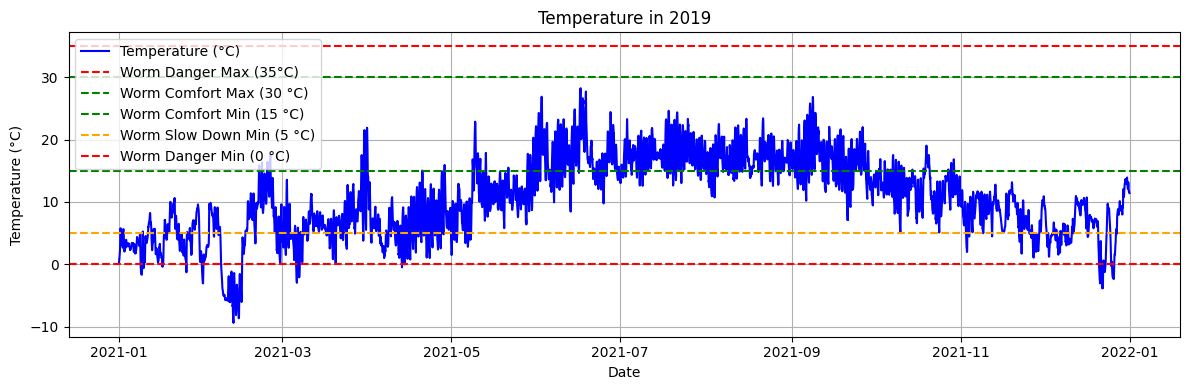

In [65]:
plt.figure(figsize=(12, 4))
plt.plot(year_2021.index, year_2021['temp'], label='Temperature (°C)', color='blue')
add_worm_temperature_zones()
plt.title("Temperature in 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Winter and summer model

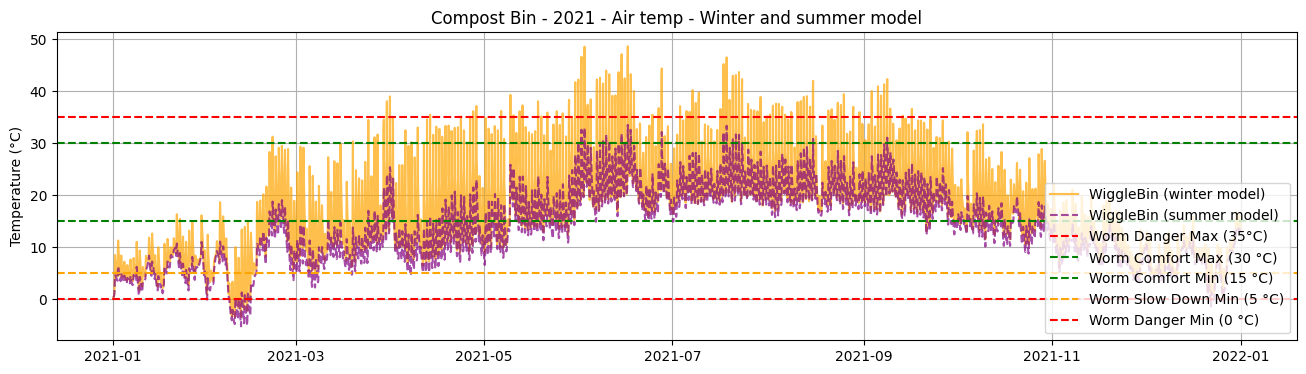

In [71]:
# air ambient
year_2021['bin_winter_model'] = simulate(
    year_2021,
    partial_shade=True,
    color='black',
    insulation=True,
    auto_venting_lid=True
)
year_2021['bin_summer_model'] = simulate(
    year_2021,
    partial_shade=True,
    color='white',
    insulation=True,
    auto_venting_lid=True,
    shade_on_hot_days=True
)

plt.figure(figsize=(16, 4))
# plt.plot(selected_summer.index, selected_summer['temp'], label='Air Temp', color='skyblue')
# plt.plot(selected_summer.index, selected_summer['soil_0_7'], label='Soil Temp', color='brown', linestyle="--", alpha=0.5)
plt.plot(year_2021.index, year_2021['bin_winter_model'], label='WiggleBin (winter model)', color='orange', alpha=0.7)
plt.plot(year_2021.index, year_2021['bin_summer_model'], label='WiggleBin (summer model)', color='purple', alpha=0.7, linestyle="--")
plt.title("Compost Bin - 2021 - Air temp - Winter and summer model")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower right')
plt.grid()
plt.show()

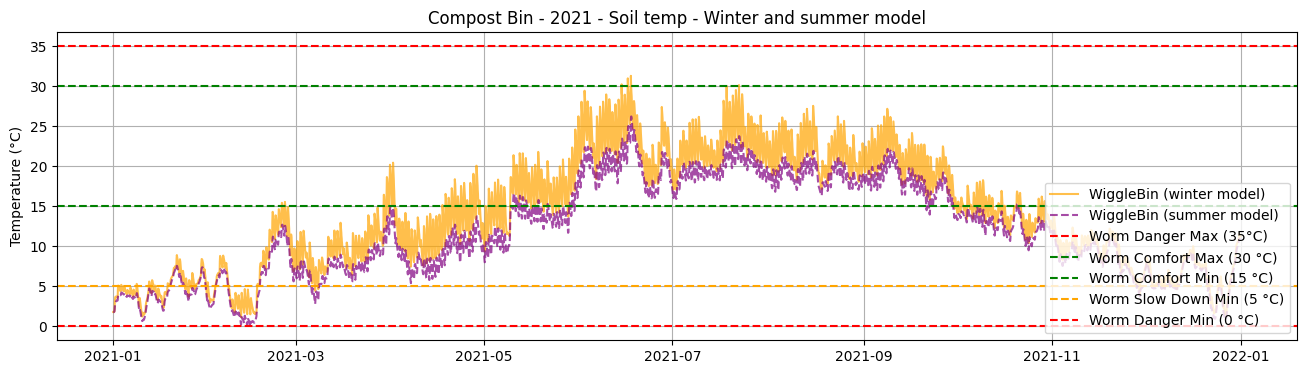

In [70]:
# soil ambient
year_2021['bin_winter_model_soil'] = simulate(
    year_2021,
    partial_shade=True,
    color='black',
    insulation=True,
    auto_venting_lid=True,
    use_soil_as_ambient=True
)
year_2021['bin_summer_model_soil'] = simulate(
    year_2021,
    partial_shade=True,
    color='white',
    insulation=True,
    auto_venting_lid=True,
    shade_on_hot_days=True,
    use_soil_as_ambient=True
)

plt.figure(figsize=(16, 4))
# plt.plot(selected_summer.index, selected_summer['temp'], label='Air Temp', color='skyblue')
# plt.plot(selected_summer.index, selected_summer['soil_0_7'], label='Soil Temp', color='brown', linestyle="--", alpha=0.5)
plt.plot(year_2021.index, year_2021['bin_winter_model_soil'], label='WiggleBin (winter model)', color='orange', alpha=0.7)
plt.plot(year_2021.index, year_2021['bin_summer_model_soil'], label='WiggleBin (summer model)', color='purple', alpha=0.7, linestyle="--")
plt.title("Compost Bin - 2021 - Soil temp - Winter and summer model")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Winter bin in Winter and Summer bin in Summer

In [73]:
year_2021['bin_mixed_model'] = year_2021.apply(
    lambda row: row['bin_winter_model'] if row.name.month in [1, 2, 3, 10, 11, 12] else row['bin_summer_model'],
    axis=1
)
year_2021['bin_mixed_model_soil'] = year_2021.apply(
    lambda row: row['bin_winter_model_soil'] if row.name.month in [1, 2, 3, 10, 11, 12] else row['bin_summer_model_soil'],
    axis=1
)

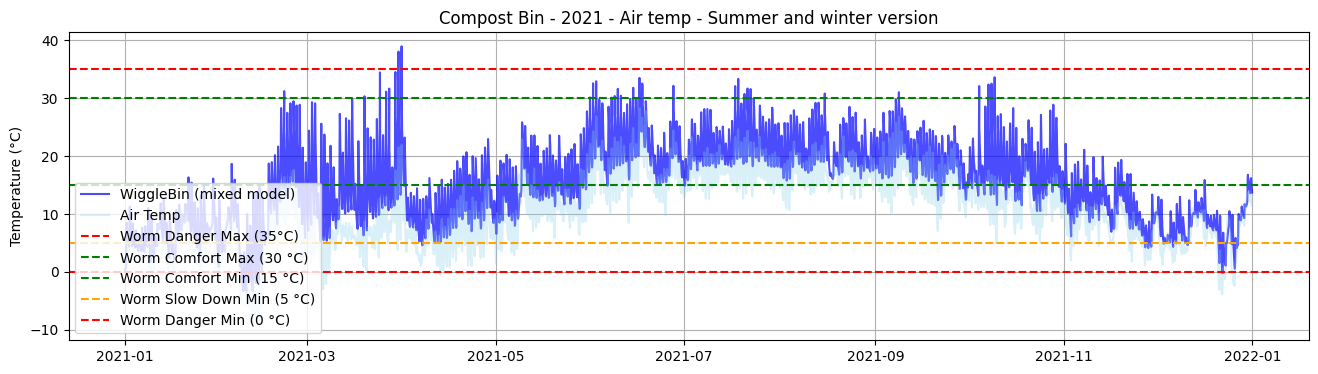

In [74]:
plt.figure(figsize=(16, 4))
plt.plot(year_2021.index, year_2021['bin_mixed_model'], label='WiggleBin (mixed model)', color='blue', alpha=0.7)
plt.plot(year_2021.index, year_2021['temp'], label='Air Temp', color='skyblue', alpha=0.3)
plt.title("Compost Bin - 2021 - Air temp - Summer and winter version")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [75]:
comparison = year_2021[['temp', 'bin_mixed_model']].describe()
print(comparison)

              temp  bin_mixed_model
count  5840.000000      5840.000000
mean     10.671180        15.350641
std       6.321906         6.717246
min      -9.396820        -3.436694
25%       5.847809         9.996344
50%      10.460236        15.748491
75%      15.624176        20.251441
max      28.253815        38.963409


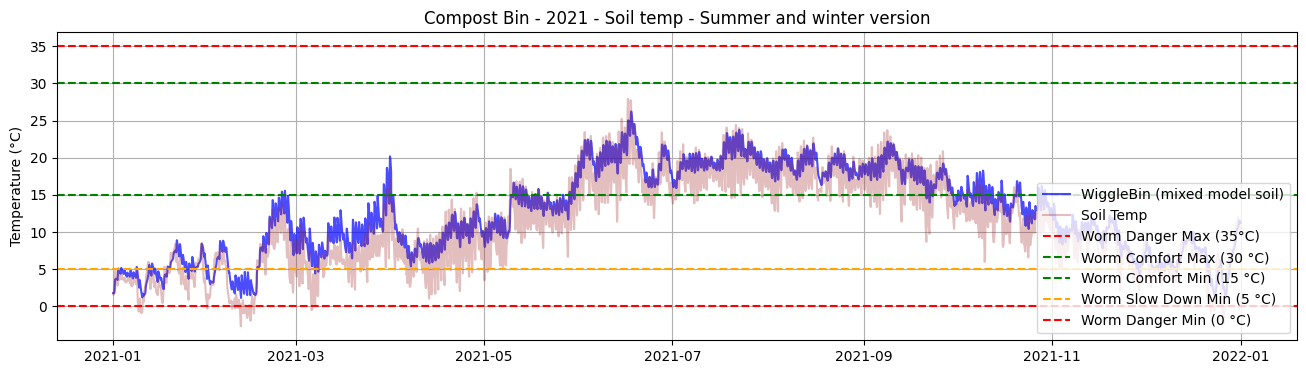

In [76]:
plt.figure(figsize=(16, 4))
plt.plot(year_2021.index, year_2021['bin_mixed_model_soil'], label='WiggleBin (mixed model soil)', color='blue', alpha=0.7)
plt.plot(year_2021.index, year_2021['soil_0_7'], label='Soil Temp', color='brown', alpha=0.3)
plt.title("Compost Bin - 2021 - Soil temp - Summer and winter version")
plt.ylabel("Temperature (°C)")
add_worm_temperature_zones()
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [77]:
comparison = year_2021[['soil_0_7', 'bin_mixed_model_soil']].describe()
print(comparison)

          soil_0_7  bin_mixed_model_soil
count  5840.000000           5840.000000
mean     10.940465             12.664790
std       6.019829              5.771277
min      -2.671478              1.141643
25%       6.082672              7.890617
50%      10.411530             12.450140
75%      16.050018             18.091565
max      27.934235             26.231066
